In [1]:
# load libraries
library(dplyr)
library("edgeR")
library(Matrix)
library(gplots)
library(RColorBrewer)
library(irlba)
library(proxy)
library(png)
library(tidyverse)
library(ComplexHeatmap)
library(here)
library(modelr)
library(preprocessCore)
devtools::load_all('/home/jpm73279/software/preprocessCore')
library("edgeR")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘proxy’


The following object is masked from ‘package:Matrix’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0.9000     ✔ readr     2.1.4     
✔ ggplot2   3.4.3          ✔ stringr   1.5.0     
✔ lubridate 1.9.2          ✔ tibble    3.2.1     
✔ purrr     1.0.2          ✔ tidyr     1.3.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() m

In [2]:
zm_working_dir <- "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/zea_mays"


#gene_bodysorghum_bicolor_tis_leaf_nmf_step_2_knn_27.out.de_novo.rds
zm_input <- here(zm_working_dir,"00.data/zea_mays.gene_body_acc_zea_may.v4_annot.counts.txt")
#input_2 <- here("/home/jpm73279/r_script_dev/lw_plotting","zea_mays.normalized_gene_acc_scores.leaf_svd_knn_100_strict.GBaccessibility.sparse")
zm_meta <- here(zm_working_dir,"00.data/Zm.leaf_annot.V5.meta.frozen.txt")
zm_gene <- here(zm_working_dir,"00.data/Zm.markers.leaf.txt")
zm_gene_DA <- here(zm_working_dir,"00.data/Zm-B73-REFERENCE-NAM_Zm00001eb.1.genes.bed")
#prefix <- "TEST_SORGHUM_TEST"

zm_meta_data <- read.delim(zm_meta)
zm_gene_markers <- read.delim(zm_gene)
zm_gene_markers <- zm_gene_markers  %>%
    arrange(type)

zm_all_markers <- zm_gene_markers$geneID

zm_raw_cpm_counts_all_genes <- read_delim(zm_input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)

zm_merged_meta_cpm_information <- left_join(zm_meta_data, zm_raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(final_annotation, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt CPM Calc
zm_merged_meta_cpm_information_copied <- zm_merged_meta_cpm_information
zm_catch <- zm_merged_meta_cpm_information_copied  %>%
    group_by(final_annotation) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()



zm_caught_values <- as_tibble(zm_catch)
zm_see <- ungroup(zm_merged_meta_cpm_information_copied)
zm_merged_meta_cpm_information_copied<- bind_cols(zm_merged_meta_cpm_information_copied,zm_caught_values)  %>% 
    rename(grouped_CPM = value)  %>% 
    mutate(species = "Zm")  %>% 
    group_by(final_annotation) %>%  
    mutate(log_cpm  = log(grouped_CPM))


#Apply quantile normalization
zm_merged_meta.quant_norm <- zm_merged_meta_cpm_information_copied  %>% 
        group_by(final_annotation)  %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

zm.quantile_normalized <- as_tibble(zm_merged_meta.quant_norm)  %>% 
    rename("quant_norm_cpm" = value)


zm_merged_meta_cpm_information_copied <- bind_cols(zm_merged_meta_cpm_information_copied, zm.quantile_normalized)


Warning message in file(file, "rt"):
“cannot open file '/scratch/jpm73279/comparative_single_cell/08.annotation_figures/zea_mays/00.data/Zm.leaf_annot.V5.meta.frozen.txt': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [3]:

pm_working_dir <- "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/oryza_sativa"


pm_input <- here(pm_working_dir,"oryza_sativa.gene_body_acc_leaf_reclustering.counts.txt")
pm_meta <- here(pm_working_dir, "os.leaf_annotation.V1.meta.txt")

pm_gene <- here(pm_working_dir,"Os.leaf_markers.from_haidong.visualize.bed")
pm_gene_DA <- here(pm_working_dir,"Osativa_323_v7.0.gene_only.bed")
#prefix <- "TEST_SORGHUM_TEST"

pm_meta_data <- read.delim(pm_meta)
pm_gene_markers <- read.delim(pm_gene)
pm_gene_markers <- pm_gene_markers  %>%
    arrange(type)



all_markers <- pm_gene_markers$geneID
pm_raw_cpm_counts_all_genes <- read_delim(pm_input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)


pm_merged_meta_cpm_information <- left_join(pm_meta_data, pm_raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(annotation_v1, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt CPM Calc
pm_merged_meta_cpm_information_copied <- pm_merged_meta_cpm_information
pm_catch <- pm_merged_meta_cpm_information_copied  %>%
    group_by(annotation_v1) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()


pm_caught_values <- as_tibble(pm_catch)
pm_see <- ungroup(pm_merged_meta_cpm_information_copied)
pm_merged_meta_cpm_information_copied <- bind_cols(pm_merged_meta_cpm_information_copied,pm_caught_values)  %>% 
    rename(grouped_CPM = value)  %>% 
    mutate(species = "pm")  %>% 
    group_by(annotation_v1) %>%  
    mutate(log_cpm  = log(grouped_CPM))

#Apply quantile normalization
pm_merged_meta.quant_norm <- pm_merged_meta_cpm_information_copied  %>% 
        group_by(annotation_v1)  %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

pm.quantile_normalized <- as_tibble(pm_merged_meta.quant_norm)  %>% 
    rename("quant_norm_cpm" = value)

#Combine and re_name
pm_merged_meta_cpm_information_copied <- bind_cols(pm_merged_meta_cpm_information_copied, pm.quantile_normalized)



Rows: 54642541 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'annotation_v1'. You can override using the `.groups` argument.


In [4]:
pm.cell_type_accessability <- pm_merged_meta_cpm_information_copied  %>% 
    ungroup()  %>% 
    mutate(species_cell_type = str_c(species, annotation_v1, sep = "."))  %>% 
    select(species_cell_type, geneID, quant_norm_cpm)  %>% 
    pivot_wider(names_from = species_cell_type, values_from = quant_norm_cpm, values_fill = 0)


zm.cell_type_accessability <- zm_merged_meta_cpm_information_copied  %>% 
    ungroup()  %>% 
    mutate(species_cell_type = str_c(species, final_annotation, sep = "."))  %>% 
    select(species_cell_type, geneID, quant_norm_cpm)  %>% 
    pivot_wider(names_from = species_cell_type, values_from = quant_norm_cpm, values_fill = 0)
    

In [5]:
Pm.Zm.key_file <- read_delim(here(pm_working_dir,"Pm.markers_from_zm.key_file.txt"), 
                             col_names = c("pm", "zm", "gene_name", "cell_type", "tis"))  %>% 
        distinct()

Rows: 449 Columns: 5
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): pm, zm, gene_name, cell_type, tis

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
### 7/23/2022 List of maarkers
good_marker_list <- c('pepc1', "cah1", "ssu1", "ssu2", "agp2", "me3", "sut1", "fama_v4v5count_1", 
                      "dct2", "shr2h", "shr2", "gl1", "ZmAAP6_4", "bhlh43","ocl1",
                     "shr1_v4v5count_1", "sut7", 'sweet13a','sweet13b','sweet13c','sweet1b', 
                      "cvp2", "fdl", "cvl2", "ad1", "fcp1", "ids1", "KCS1", 
                      "mdh6", "vt2","ZmAPL", "ZmSWEET11", "zyb14", "ocl5", "ocl4", "hkt1_2", "kch1",
                      "slac_v4v5count_1", "bhlh43", "dct2", "KCS1", "scr1", "ZmLAX2", "acl5", "pdf1", 
                      "xcp1", "gpat12", "pdf1", "pdf2","snd1",
                      "pdf2", "ZmLRD3", "ad1", "ZmSMXL4_v4v5count_1", "SID1", "ZmSMXL5")

good_gene_markers <- Pm.Zm.key_file  %>% 
    filter(gene_name %in% good_marker_list)  %>% 
    select(-cell_type, -tis)



In [7]:
head(good_gene_markers)

pm,zm,gene_name
<chr>,<chr>,<chr>
RLN28288.1,Zm00001eb408920,sweet13a
RLN01113.1,Zm00001eb408920,sweet13a
RLM98289.1,Zm00001eb408920,sweet13a
RLN28288.1,Zm00001eb408900,sweet13b
RLN01113.1,Zm00001eb408900,sweet13b
RLM98289.1,Zm00001eb408900,sweet13b


In [8]:
final_combined_dataset <- left_join(good_gene_markers, zm.cell_type_accessability, by = c("zm" = "geneID"))  %>% 
    left_join(., pm.cell_type_accessability, by = c("pm" = "geneID"))  %>% 
    rowwise()  %>% 
    mutate(unique_count = n())

generate_corr_matrix <- final_combined_dataset  %>% 
    select(-pm, -zm, -gene_name, -unique_count)

generate_corr_matrix[is.na(generate_corr_matrix)] = 0

cell_type_corr_matrix <- cor(generate_corr_matrix)

In [9]:
cell_type_corr_matrix <- cor(generate_corr_matrix)

In [10]:
sum(is.na(generate_corr_matrix))

[1] 0

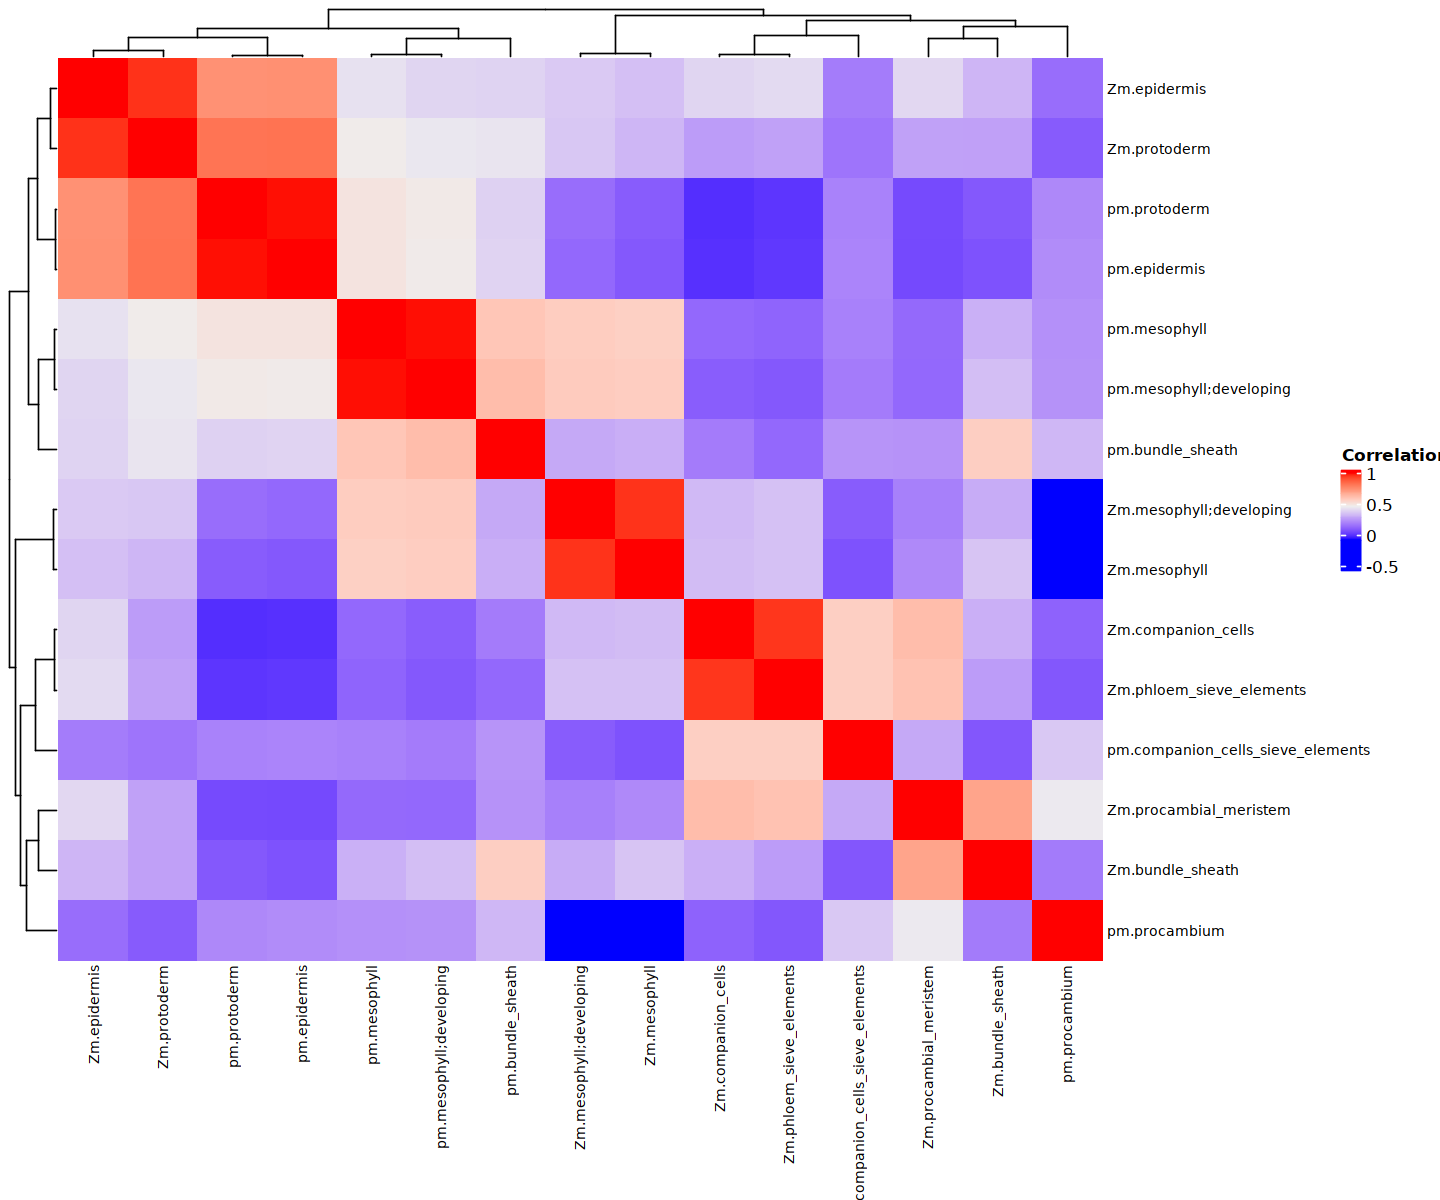

In [11]:
library(ComplexHeatmap)

options(repr.plot.width=12, repr.plot.height=10)
zm_vs_pm_all_vs_all_markers <- Heatmap(cell_type_corr_matrix,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))

zm_vs_pm_all_vs_all_markers

In [12]:
zm.cell_types <- left_join(good_gene_markers, zm.cell_type_accessability, by = c("zm" = "geneID"))  %>% 
    select(-pm, -zm, -gene_name)
pm.cell_types <- left_join(good_gene_markers, pm.cell_type_accessability, by = c("pm" = "geneID"))  %>% 
    select(-pm, -zm, -gene_name)



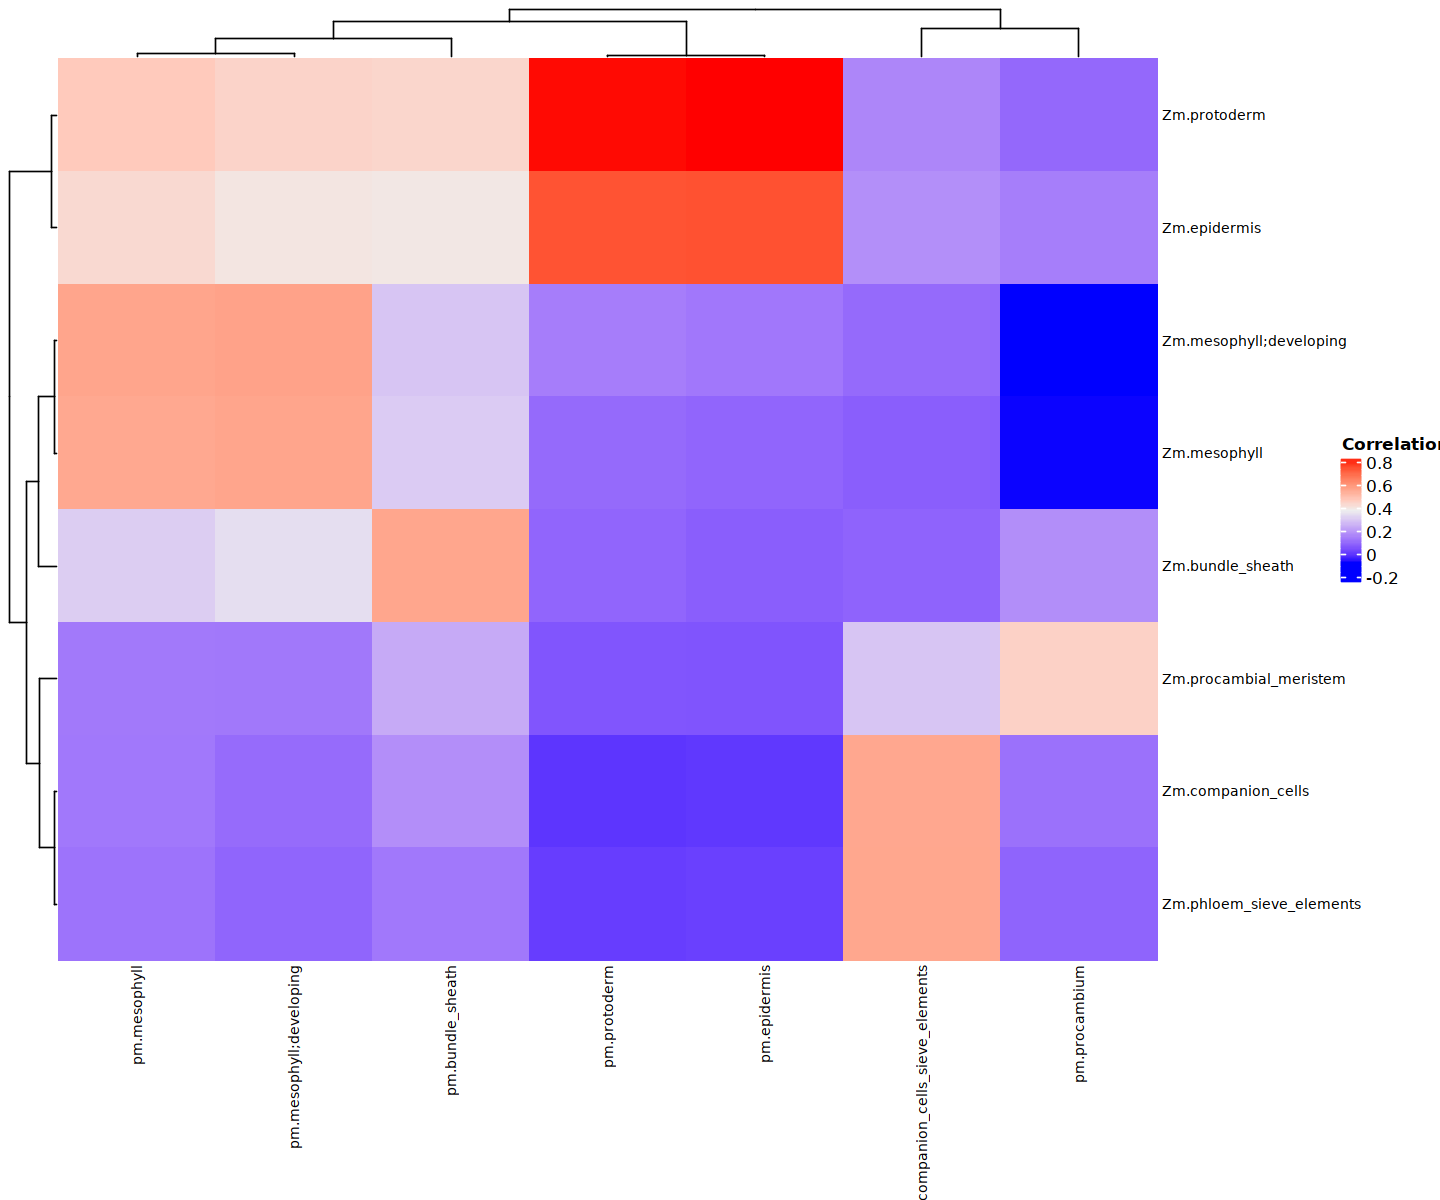

In [13]:



options(repr.plot.width=12, repr.plot.height=10)

zm.cell_types[is.na(zm.cell_types)] = 0
pm.cell_types[is.na(pm.cell_types)] = 0
sep_corr_matrix <- cor(zm.cell_types, pm.cell_types)
zm_vs_pm_markers <- Heatmap(sep_corr_matrix,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))
zm_vs_pm_markers




In [14]:
sep_corr_matrix

,pm.bundle_sheath,pm.companion_cells_sieve_elements,pm.epidermis,pm.mesophyll,pm.mesophyll;developing,pm.procambium,pm.protoderm
Zm.bundle_sheath,0.5637554,0.08566844,0.073946453,0.3101464,0.34515699,0.17566218,0.089303759
Zm.companion_cells,0.1770773,0.56112371,-0.001415942,0.1283448,0.10246712,0.11425243,-0.006537871
Zm.epidermis,0.3980334,0.17851173,0.750685699,0.4328808,0.40252831,0.14142642,0.747023972
Zm.mesophyll,0.3065056,0.07449956,0.089548959,0.5592177,0.56658875,-0.06906061,0.099676254
Zm.mesophyll;developing,0.2927968,0.09985206,0.128116957,0.5675325,0.57344672,-0.07112936,0.140969795
Zm.phloem_sieve_elements,0.1283751,0.56206016,0.013999822,0.1183969,0.08882665,0.08618840,0.009150260
Zm.procambial_meristem,0.2355685,0.29256452,0.053675218,0.1323244,0.12859890,0.45375188,0.056043535
Zm.protoderm,0.4413838,0.15962751,0.828203811,0.4733747,0.44826709,0.09641833,0.824815172


In [15]:
colnames(pm.cell_types)

[1] "pm.bundle_sheath"                  "pm.companion_cells_sieve_elements"
[3] "pm.epidermis"                      "pm.mesophyll"                     
[5] "pm.mesophyll;developing"           "pm.procambium"                    
[7] "pm.protoderm"

In [82]:
## Generating Orderer on Marker Genes 
Pm_order <- c('pm.epidermis',
    'pm.protoderm',
    'pm.mesophyll',
    'pm.mesophyll;developing',
    'pm.bundle_sheath',
    'pm.procambium',
    'pm.companion_cells_sieve_elements')

zm_order <- c('Zm.epidermis',
'Zm.protoderm',
'Zm.mesophyll',
'Zm.mesophyll;developing',
'Zm.bundle_sheath',
'Zm.procambial_meristem',
'Zm.companion_cells',
'Zm.phloem_sieve_elements'
)

zm.cell_types.dropped <- zm.cell_types
Pm.cell_types.dropped <- pm.cell_types 

options(repr.plot.width=12, repr.plot.height=10)
marker_corr_matrix <- cor((Pm.cell_types.dropped), (zm.cell_types.dropped))


zm_pm_markers <- Heatmap(marker_corr_matrix,
        row_order = Pm_order,
        column_order = zm_order,
        column_names_gp = grid::gpar(fontsize = 8),
        row_names_gp = grid::gpar(fontsize = 8),
        heatmap_legend_param = list(
            title = "Correlation",
            legend_width = unit(6, "cm")))
#zm_vs_Pm_markers_ordered

In [17]:
## Working now on Single Copy Ortholouges

zm_base <- "Zm"
Pm_base <- "Sobic"

Pm_vs_Zm_orthos <- read_delim("/home/jpm73279/genome_downloads/Pmiliaceum/markers/Pmiliaceum.prot__v__Zm-B73.prot.tsv") 

#Gross output here that needs to be fixed from orthofinder.
colnames(Pm_vs_Zm_orthos) <- sub("-", "_", colnames(Pm_vs_Zm_orthos), fixed = TRUE)

Rows: 19096 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): Orthogroup, Pmiliaceum.prot, Zm-B73.prot

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [18]:
head(Pm_vs_Zm_orthos)

Orthogroup,Pmiliaceum.prot,Zm_B73.prot
<chr>,<chr>,<chr>
OG0000001,"RLM62180.1, RLN04789.1, RLM79109.1, RLM75542.1, RLN30386.1, RLN04975.1, RLN13367.1, RLN19929.1, RLM54729.1",Zm00001eb279530_P001
OG0000003,"RLM57887.1, RLM98523.1, RLN00348.1",Zm00001eb276920_P002
OG0000004,"RLM65306.1, RLN29177.1, RLM97759.1, RLM59072.1",Zm00001eb050830_P001
OG0000004,"RLN15447.1, RLN38937.1, RLN42042.1, RLN19986.1, RLN39102.1, RLN15502.1, RLM70020.1, RLM57957.1, RLM58531.1, RLM69827.1, RLM74687.1, RLM74257.1, RLM66269.1, RLM64739.1, RLN17339.1, RLN08931.1, RLN15971.1, RLN38648.1, RLN15536.1, RLM99065.1, RLM97861.1, RLN39039.1, RLN19583.1, RLN40296.1, RLN33753.1",Zm00001eb116750_P003
OG0000006,"RLM85119.1, RLN36345.1, RLM87719.1, RLN33485.1",Zm00001eb321100_P001
OG0000006,"RLN35784.1, RLM86101.1, RLM85420.1","Zm00001eb104120_P001, Zm00001eb104150_P001"


In [19]:
Pm_vs_Zm_orthos.fixed <- Pm_vs_Zm_orthos  %>% 
    rowwise() %>% 
    mutate(Pm_count = str_count(Pmiliaceum.prot	, pattern = ","))  %>% 
    mutate(Zm_count = str_count(Zm_B73.prot, pattern = ",")) %>%
    dplyr::filter(Pm_count == 0 & Zm_count == 0) %>% 
    mutate(zm_gene = str_replace(Zm_B73.prot, "_P00.*", "")) %>%
    mutate(Pm_gene = Pmiliaceum.prot)
    


In [20]:
head(Pm_vs_Zm_orthos.fixed)

Orthogroup,Pmiliaceum.prot,Zm_B73.prot,Pm_count,Zm_count,zm_gene,Pm_gene
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
OG0000007,RLM84336.1,Zm00001eb305320_P001,0,0,Zm00001eb305320,RLM84336.1
OG0000007,RLM58839.1,Zm00001eb416480_P001,0,0,Zm00001eb416480,RLM58839.1
OG0000007,RLM55359.1,Zm00001eb281100_P001,0,0,Zm00001eb281100,RLM55359.1
OG0000007,RLN19337.1,Zm00001eb058940_P001,0,0,Zm00001eb058940,RLN19337.1
OG0000007,RLM99622.1,Zm00001eb116780_P001,0,0,Zm00001eb116780,RLM99622.1
OG0000007,RLM85633.1,Zm00001eb305300_P001,0,0,Zm00001eb305300,RLM85633.1


In [21]:
pm.zm.single_copy <- Pm_vs_Zm_orthos.fixed  %>% 
    select(Orthogroup, zm_gene, Pm_gene)

In [22]:
pm.cell_types.all_orthos <- left_join(pm.zm.single_copy, pm.cell_type_accessability, by = c("Pm_gene" = "geneID")) %>% 
    drop_na()


zm.cell_types.all_orthos <- left_join(pm.zm.single_copy, zm.cell_type_accessability, by = c("zm_gene" = "geneID")) %>% 
    dplyr::filter(Pm_gene %in% pm.cell_types.all_orthos$Pm_gene)


In [23]:
dim(pm.cell_types.all_orthos)

[1] 4071   10

In [24]:
pm.cell_types.all_orthos.final <- pm.cell_types.all_orthos  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -Pm_gene)  %>% 
    replace(is.na(.), 0)

zm.cell_types.all_orthos.final <- zm.cell_types.all_orthos  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -Pm_gene)  %>% 
    replace(is.na(.), 0)

In [25]:
dim(zm.cell_types.all_orthos.final)
dim(pm.cell_types.all_orthos)

[1] 4071    8

[1] 4071   10

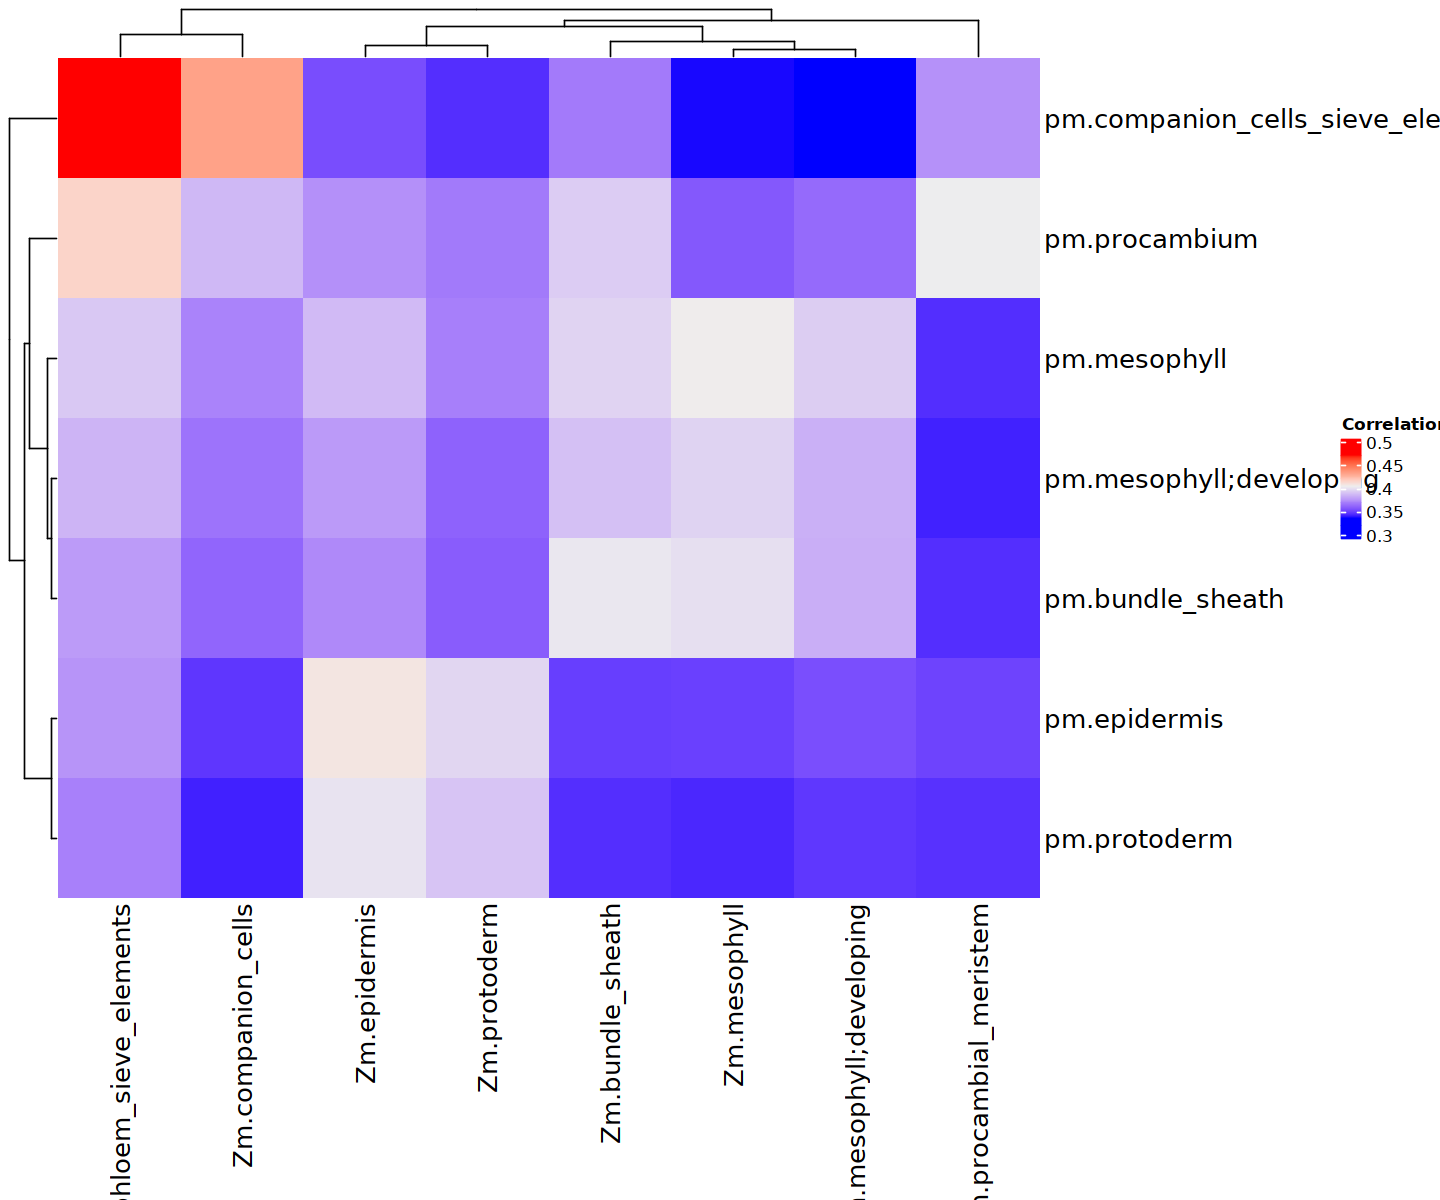

In [26]:
options(repr.plot.width=12, repr.plot.height=10)
all_orthos_corr <- cor((pm.cell_types.all_orthos.final), (zm.cell_types.all_orthos.final))
Heatmap(all_orthos_corr,
                                      column_names_gp = grid::gpar(fontsize = 15),
                                      row_names_gp = grid::gpar(fontsize = 15),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))

# Selecting the 1000-2000 most variable single copy orthos

In [27]:
head(pm.cell_types.all_orthos)
head(zm.cell_types.all_orthos)

Orthogroup,zm_gene,Pm_gene,pm.bundle_sheath,pm.companion_cells_sieve_elements,pm.epidermis,pm.mesophyll,pm.mesophyll;developing,pm.procambium,pm.protoderm
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OG0000007,Zm00001eb305320,RLM84336.1,0.0000000,2.5641683,1.0205927,0.0000000,0.9407324,0.0000000,0.2820392
OG0000007,Zm00001eb416480,RLM58839.1,0.9952662,0.6410421,10.8863218,0.3930849,0.9407324,0.0000000,10.2944306
OG0000007,Zm00001eb281100,RLM55359.1,13.4360935,6.4104208,22.6231375,13.4959150,11.6023668,6.1443123,23.4092531
OG0000007,Zm00001eb058940,RLN19337.1,124.0765174,30.7700197,103.0798595,137.5797160,126.5285138,36.4269946,100.2649335
OG0000007,Zm00001eb116780,RLM99622.1,0.3317554,1.2820842,0.3401976,0.0000000,0.0000000,0.0000000,0.2820392
OG0000007,Zm00001eb305300,RLM85633.1,0.6635108,0.0000000,25.0045204,0.2620566,0.6271550,0.8777589,20.3068220


Orthogroup,zm_gene,Pm_gene,Zm.bundle_sheath,Zm.companion_cells,Zm.epidermis,Zm.mesophyll,Zm.mesophyll;developing,Zm.phloem_sieve_elements,Zm.procambial_meristem,Zm.protoderm
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OG0000007,Zm00001eb305320,RLM84336.1,10.126029,14.527295,76.690981,13.910486,12.672183,8.211259,18.449129,55.601132
OG0000007,Zm00001eb416480,RLM58839.1,4.882193,3.631824,8.369394,4.015398,2.534437,6.386535,3.689826,5.054648
OG0000007,Zm00001eb281100,RLM55359.1,3.978083,0.000000,7.515374,19.933582,7.603310,3.193267,0.000000,12.131156
OG0000007,Zm00001eb058940,RLN19337.1,143.753451,106.230848,155.602413,186.142374,169.807256,145.065581,84.865995,131.673589
OG0000007,Zm00001eb116780,RLM99622.1,3.254795,0.000000,10.760650,2.581327,2.534437,2.737086,0.000000,4.549183
OG0000007,Zm00001eb305300,RLM85633.1,9.764385,9.987516,42.017776,6.596725,0.000000,13.685432,11.069478,42.206314


In [28]:
head(pm.cell_types.all_orthos)

Orthogroup,zm_gene,Pm_gene,pm.bundle_sheath,pm.companion_cells_sieve_elements,pm.epidermis,pm.mesophyll,pm.mesophyll;developing,pm.procambium,pm.protoderm
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OG0000007,Zm00001eb305320,RLM84336.1,0.0000000,2.5641683,1.0205927,0.0000000,0.9407324,0.0000000,0.2820392
OG0000007,Zm00001eb416480,RLM58839.1,0.9952662,0.6410421,10.8863218,0.3930849,0.9407324,0.0000000,10.2944306
OG0000007,Zm00001eb281100,RLM55359.1,13.4360935,6.4104208,22.6231375,13.4959150,11.6023668,6.1443123,23.4092531
OG0000007,Zm00001eb058940,RLN19337.1,124.0765174,30.7700197,103.0798595,137.5797160,126.5285138,36.4269946,100.2649335
OG0000007,Zm00001eb116780,RLM99622.1,0.3317554,1.2820842,0.3401976,0.0000000,0.0000000,0.0000000,0.2820392
OG0000007,Zm00001eb305300,RLM85633.1,0.6635108,0.0000000,25.0045204,0.2620566,0.6271550,0.8777589,20.3068220


In [29]:
combined_pm_zm <- full_join(pm.cell_types.all_orthos, zm.cell_types.all_orthos)

combined_pm_zm.subset <- combined_pm_zm  %>% 
    #dplyr::select(-zm_gene, -pm_gene) %>% 
    #mutate(row_n = row_number()) %>%
    mutate(ortho_unique = str_c(Orthogroup, zm_gene, Pm_gene, sep = "__"))  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -Pm_gene)

Joining with `by = join_by(Orthogroup, zm_gene, Pm_gene)`


In [30]:
combined_pm_zm.subset.mean.var <- combined_pm_zm.subset %>%
    pivot_longer(!ortho_unique, names_to = "cell_type", values_to = "score")  %>% 
    group_by(ortho_unique)  %>% 
      summarize(mean = mean(score),
            var = var(score))

regression <- loess(var ~ mean, data=combined_pm_zm.subset.mean.var)

combined_pm_zm.subset.mean.var.final <- combined_pm_zm.subset.mean.var %>% 
    add_residuals(regression)  %>% 
    arrange(resid, desc = FALSE)  %>% 
    top_n(2000)

Selecting by resid


In [31]:
combined_pm_zm.subset.mean.var.final.split <- combined_pm_zm.subset.mean.var.final  %>% 
    separate(ortho_unique, into = c("Orthogroup", "zm_gene", "Pm_gene"), sep = "__")  %>% 
    dplyr::select(Orthogroup, zm_gene, Pm_gene)

In [32]:
pm.cell_types.var_orthos.final <- left_join(combined_pm_zm.subset.mean.var.final.split, pm.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -Pm_gene)  %>% 
    replace(is.na(.), 0)

zm.cell_types.var_orthos.final <- left_join(combined_pm_zm.subset.mean.var.final.split,zm.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -Pm_gene)  %>% 
    replace(is.na(.), 0)

Joining with `by = join_by(Orthogroup, zm_gene, Pm_gene)`
Joining with `by = join_by(Orthogroup, zm_gene, Pm_gene)`


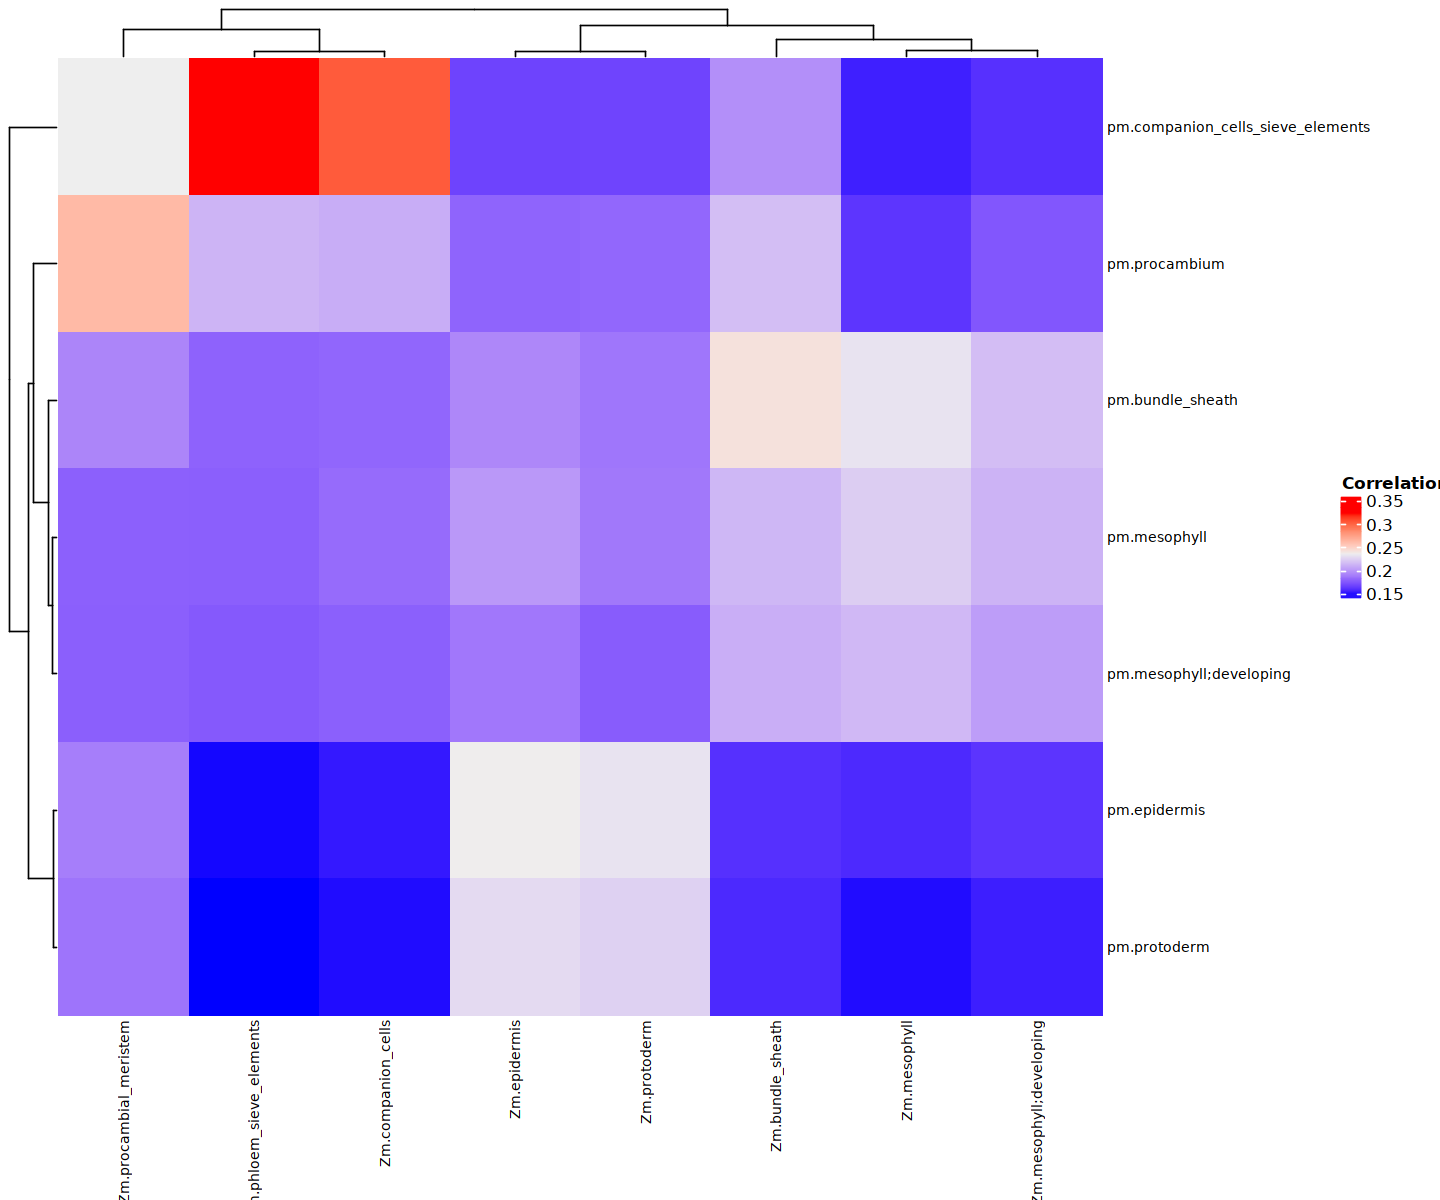

In [33]:
options(repr.plot.width=12, repr.plot.height=10)
var.orthos.final <- cor((pm.cell_types.var_orthos.final), (zm.cell_types.var_orthos.final))
Heatmap(var.orthos.final,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))

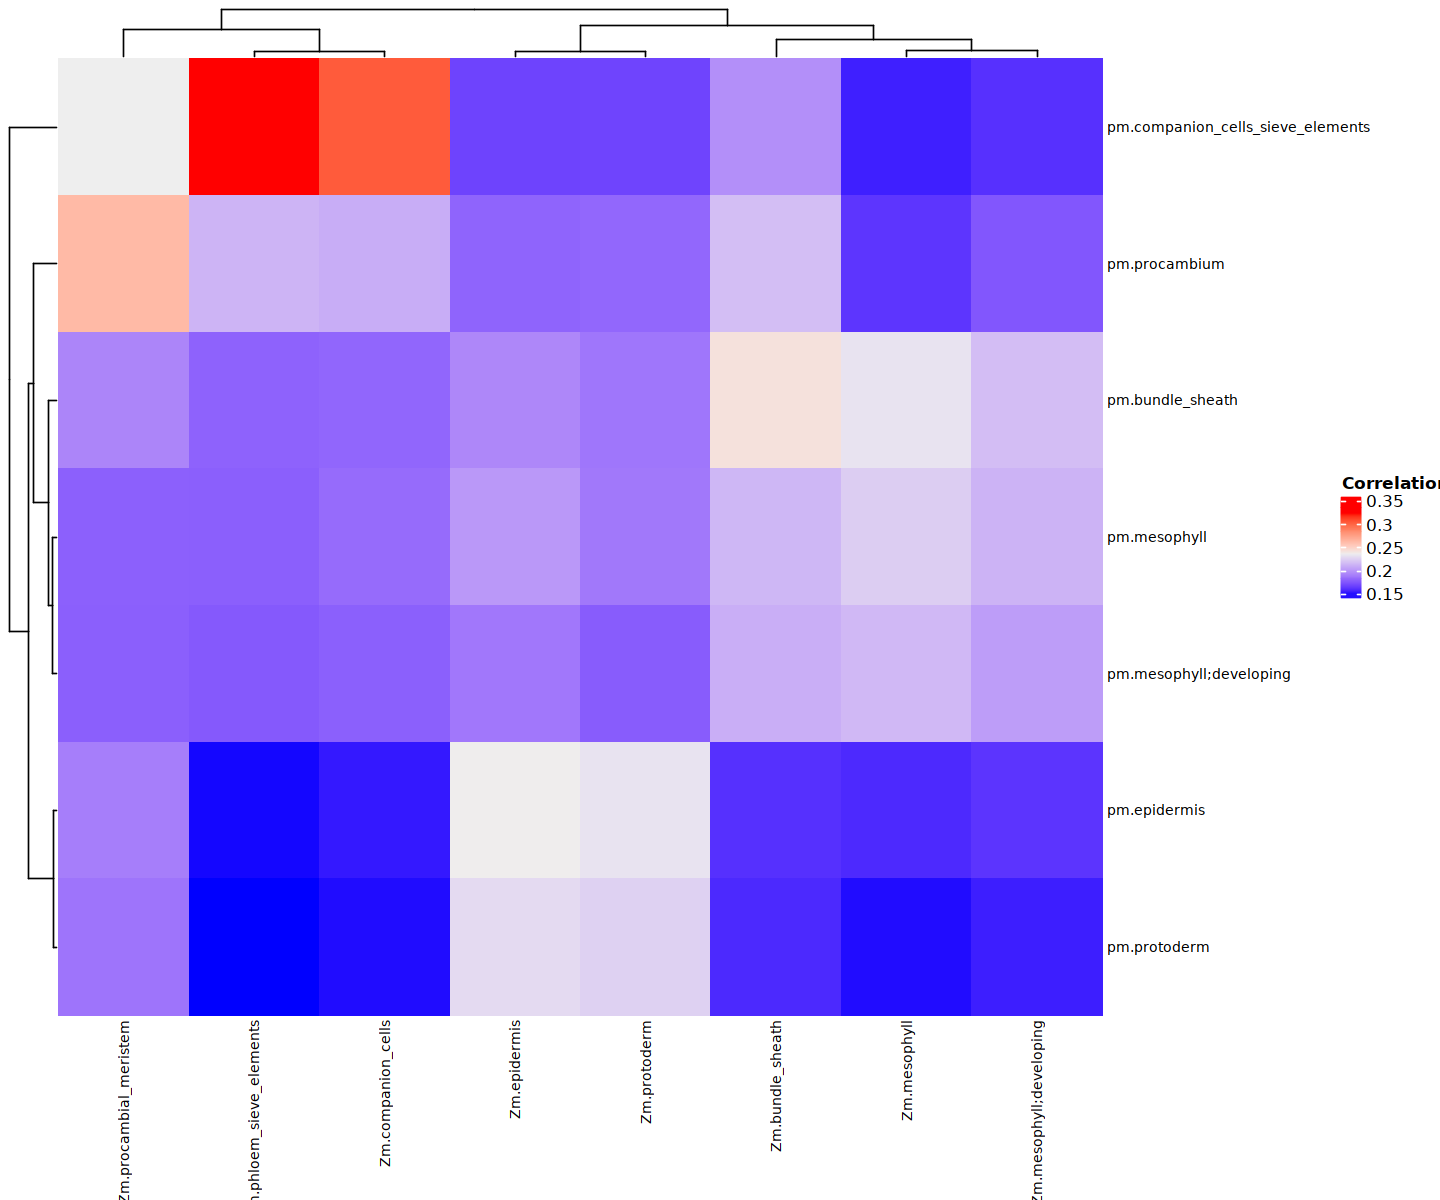

In [34]:
pm.cell_types.var_orthos.final.sub_select <- pm.cell_types.var_orthos.final

zm.cell_types.var_orthos.final.sub_select <- zm.cell_types.var_orthos.final

options(repr.plot.width=12, repr.plot.height=10)
var.orthos.final <- cor((pm.cell_types.var_orthos.final.sub_select), (zm.cell_types.var_orthos.final.sub_select))
zm_vs_pm_2000_orthos <-  Heatmap(var.orthos.final,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))
zm_vs_pm_2000_orthos


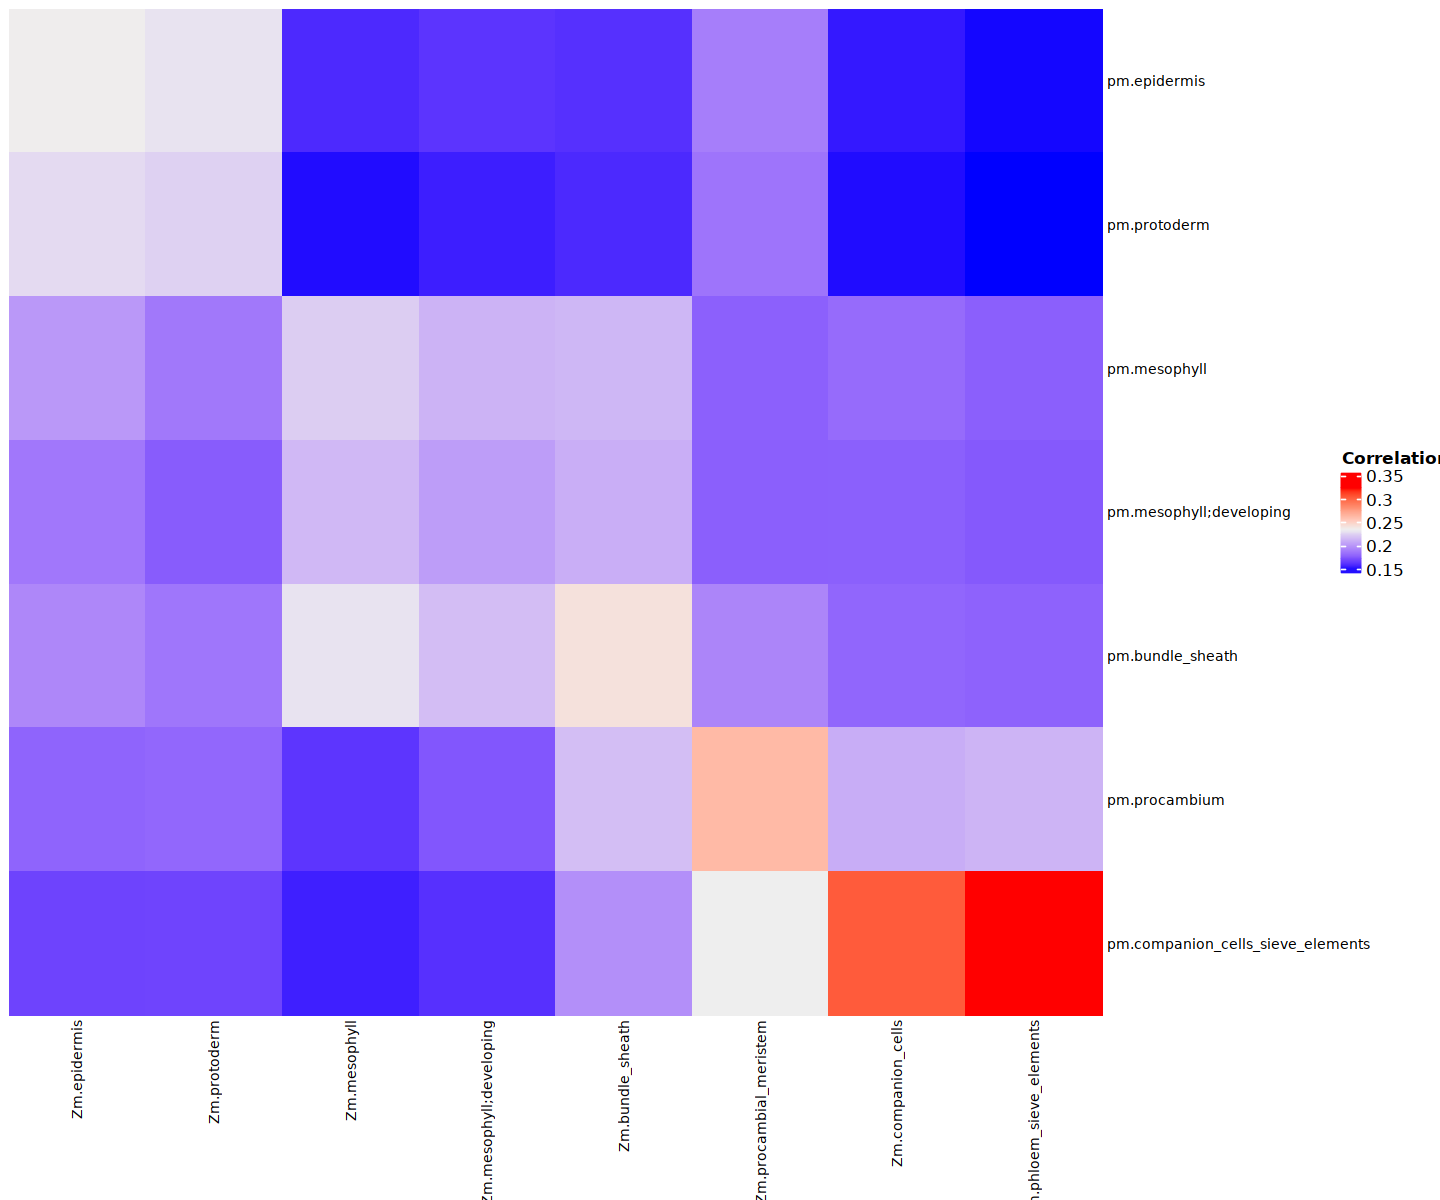

In [35]:
pm.cell_types.var_orthos.final.sub_select <- pm.cell_types.var_orthos.final 

zm.cell_types.var_orthos.final.sub_select <- zm.cell_types.var_orthos.final


pm_order <- c('pm.epidermis',
    'pm.protoderm',
    'pm.mesophyll',
    'pm.mesophyll;developing',
    'pm.bundle_sheath',
    'pm.procambium',
    'pm.companion_cells_sieve_elements')

zm_order <- c('Zm.epidermis',
'Zm.protoderm',
'Zm.mesophyll',
'Zm.mesophyll;developing',
'Zm.bundle_sheath',
'Zm.procambial_meristem',
'Zm.companion_cells',
'Zm.phloem_sieve_elements'
)


options(repr.plot.width=12, repr.plot.height=10)
var.orthos.final <- cor((pm.cell_types.var_orthos.final.sub_select), (zm.cell_types.var_orthos.final.sub_select))
zm_vs_pm_2000_orthos_ordered <- Heatmap(var.orthos.final,
        row_order = pm_order,
        column_order = zm_order,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))
zm_vs_pm_2000_orthos_ordered

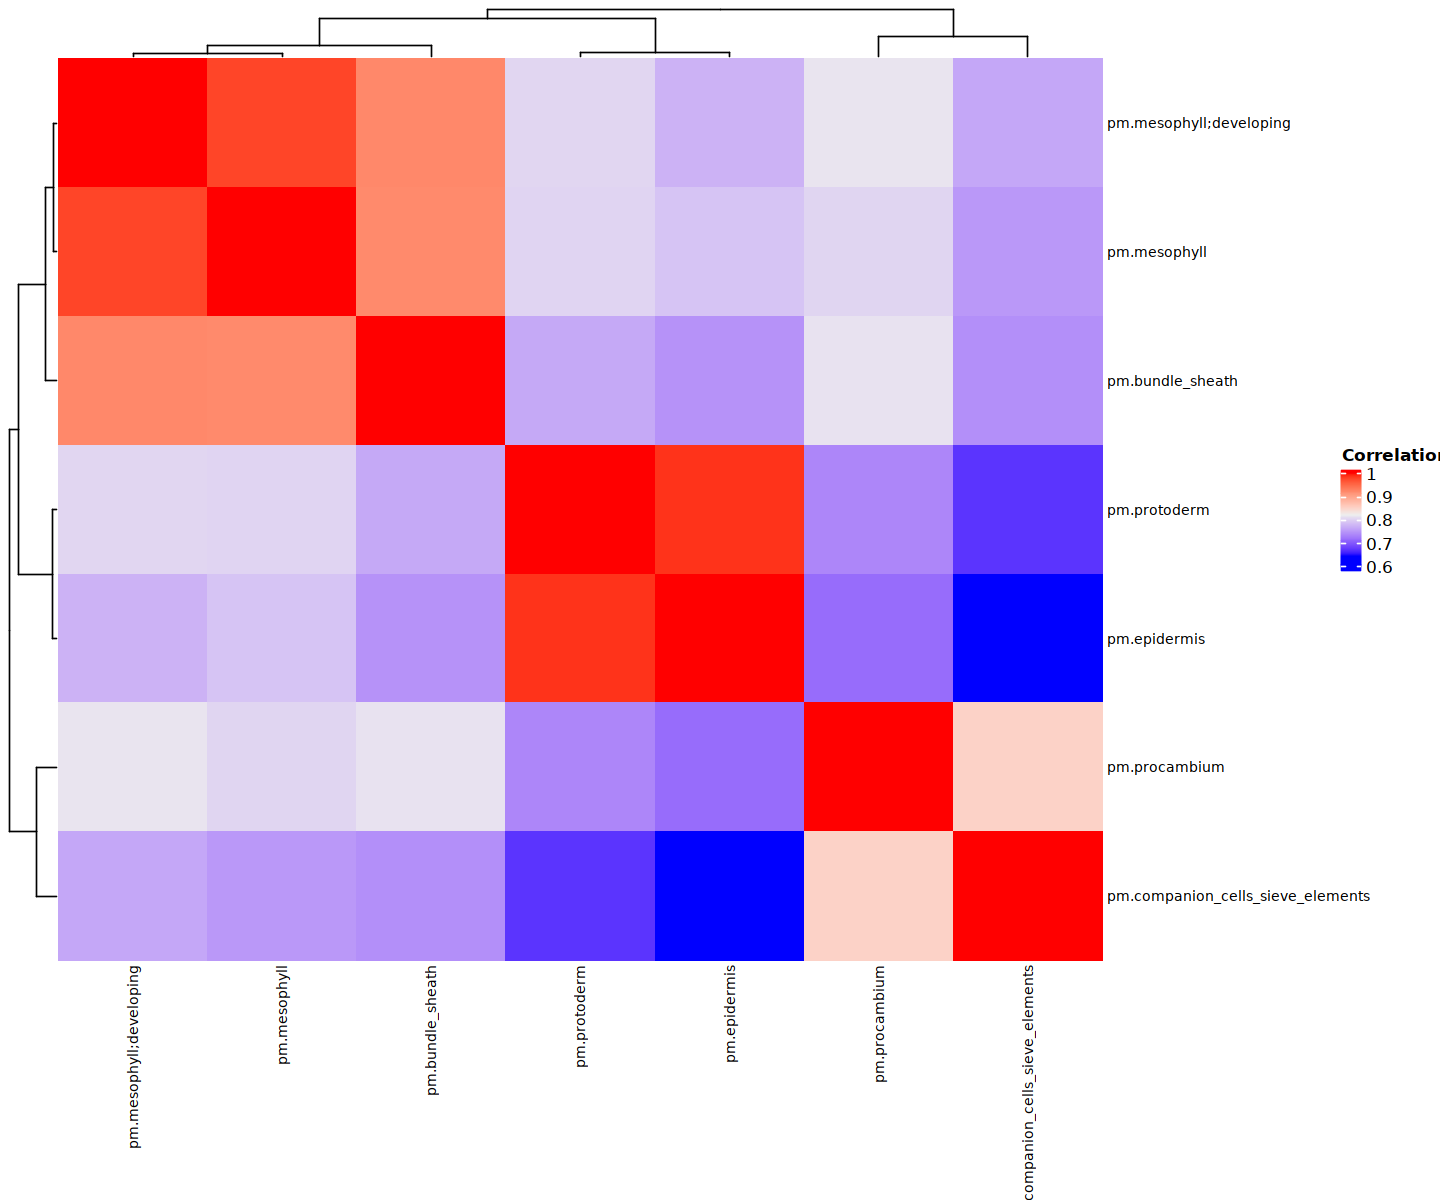

In [36]:
var.orthos.final <- cor((pm.cell_types.var_orthos.final.sub_select), (pm.cell_types.var_orthos.final.sub_select))
pm_vs_pm_2000_orthos<-  Heatmap(var.orthos.final,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))

pm_vs_pm_2000_orthos

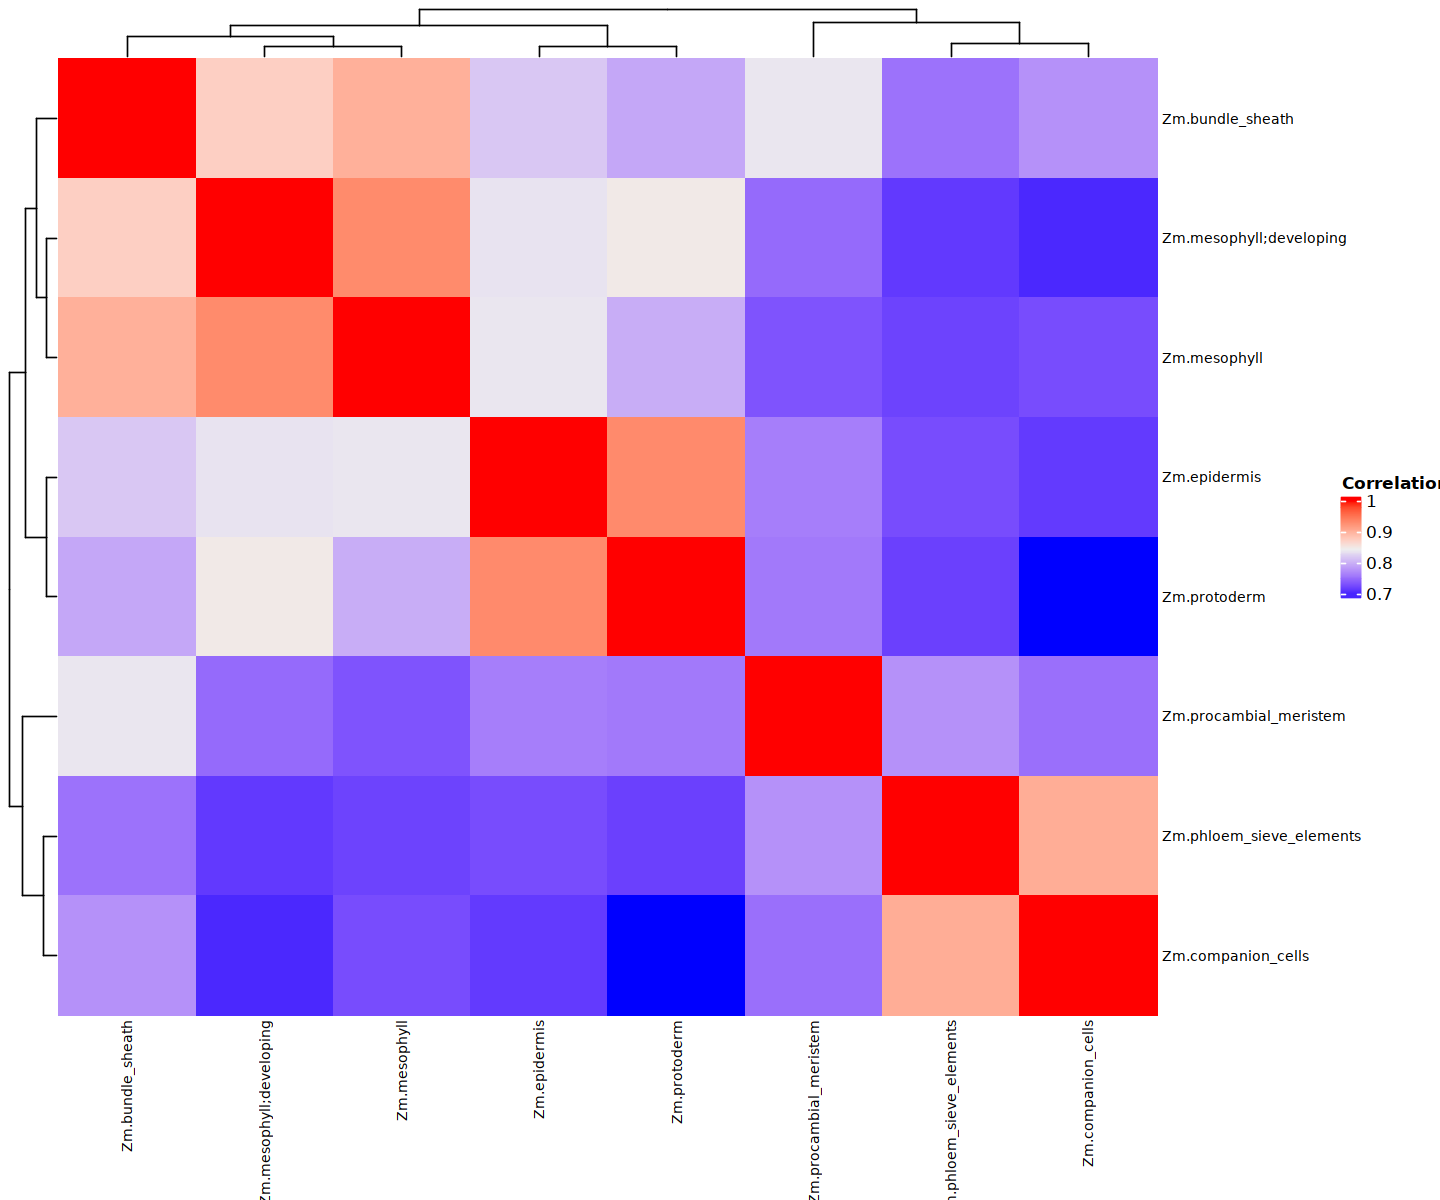

In [37]:
var.orthos.final <- cor((zm.cell_types.var_orthos.final), (zm.cell_types.var_orthos.final))
zm_vs_zm_2000_orthos <- Heatmap(var.orthos.final,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))
zm_vs_zm_2000_orthos 


Joining with `by = join_by(Orthogroup, zm_gene, Pm_gene)`
Joining with `by = join_by(Orthogroup, zm_gene, Pm_gene)`


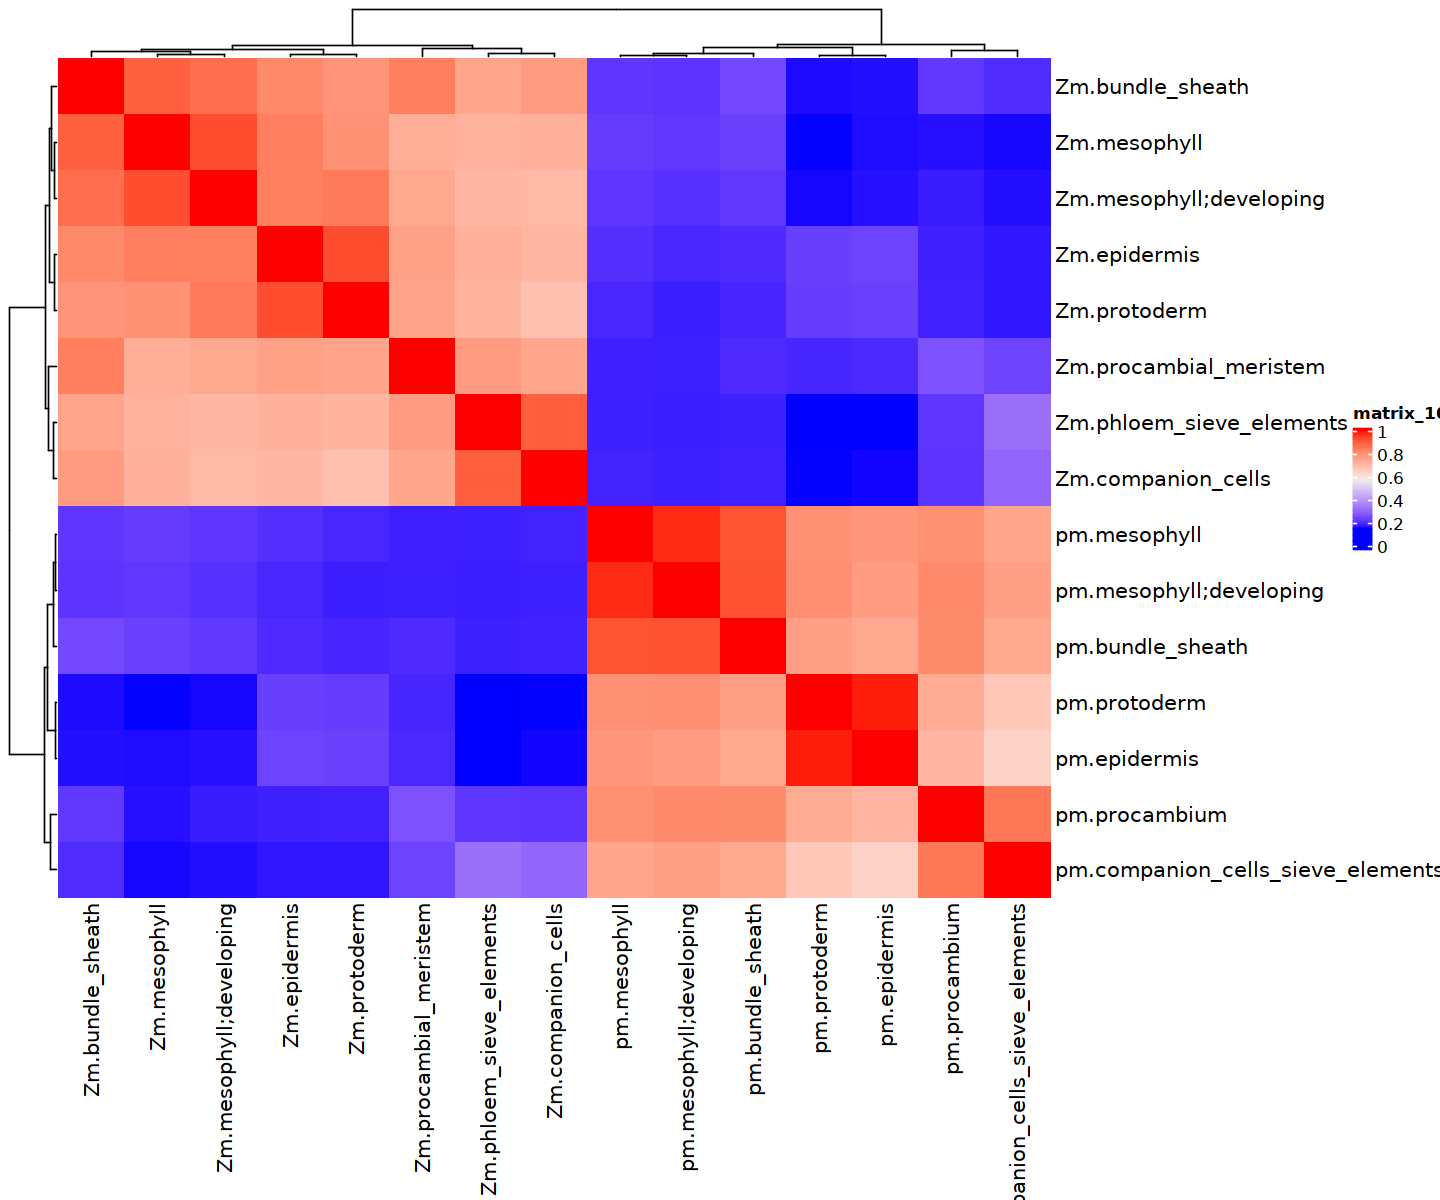

In [38]:
## Note that useful - Skipping this 
combined_pm_zm.subset.mean.var.final.split <- combined_pm_zm.subset.mean.var.final  %>% 
    separate(ortho_unique, into = c("Orthogroup", "zm_gene", "Pm_gene"), sep = "__")  %>% 
    dplyr::select(Orthogroup, zm_gene, Pm_gene)

pm.cell_types.var_orthos.final <- left_join(combined_pm_zm.subset.mean.var.final.split, pm.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -Pm_gene)  %>% 
    replace(is.na(.), 0)

zm.cell_types.var_orthos.final <- left_join(combined_pm_zm.subset.mean.var.final.split,zm.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -Pm_gene)  %>% 
    replace(is.na(.), 0)

all_vs_all <- bind_cols(zm.cell_types.var_orthos.final, pm.cell_types.var_orthos.final)

# Convert all elements to numeric
all_vs_all <- apply(all_vs_all, 2, function(x) as.numeric(as.character(x)))
# Convert back to matrix
all_vs_all <- as.matrix(all_vs_all)
all_vs_all[is.na(all_vs_all)] = 0

cell_type_corr_matrix <- cor(all_vs_all)





options(repr.plot.width=12, repr.plot.height=10)
Heatmap(cell_type_corr_matrix)

In [39]:
# Selecting Zm and Pm Orthos more efficiently 

Pm_vs_Zm_orthos.fixed <- Pm_vs_Zm_orthos  %>% 
    rowwise() %>% 
    mutate(Pm_count = str_count(Pmiliaceum.prot, pattern = ","))  %>% 
    mutate(Zm_count = str_count(Zm_B73.prot, pattern = ",")) %>%
    dplyr::filter(Pm_count <= 4 & Zm_count == 0) #%>% 
    #mutate(zm_gene = str_replace(Zm_B73.prot, "_P00.*", "")) %>%
    #mutate(Pm_gene = Pmiliaceum.prot)
    




In [40]:
head(pm_merged_meta_cpm_information_copied)

annotation_v1,geneID,counts,grouped_CPM,species,log_cpm,quant_norm_cpm
<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
bundle_sheath,C2845_PMCG10002,2296,380.855192,pm,5.942419,380.855192
bundle_sheath,C2845_PMCG10004,151,25.047532,pm,3.220775,25.047532
bundle_sheath,C2845_PMCG10007,25,4.146942,pm,1.422371,4.146942
bundle_sheath,C2845_PMCG10009,82,13.601971,pm,2.610215,13.601971
bundle_sheath,C2845_PMCG10011,221,36.658971,pm,3.601658,36.658971
bundle_sheath,C2845_PMCG10012,221,36.658971,pm,3.601658,36.658971


In [41]:
pm_gemes_most_highly_acc <- Pm_vs_Zm_orthos.fixed  %>% 
    select(Orthogroup, Pmiliaceum.prot)  %>% 
    rowwise()  %>% 
    separate_rows(Pmiliaceum.prot, sep = ",\\s*")  %>% 
    mutate(Pm_gene = Pmiliaceum.prot)  %>% 
    left_join(.,pm_merged_meta_cpm_information_copied, by = c("Pm_gene" = "geneID"))  %>% 
    dplyr::filter(is.na(quant_norm_cpm) != TRUE)  %>% 
      group_by(Orthogroup) %>%
      slice_sample(weight_by = grouped_CPM, n = 1) %>%
      ungroup()  %>% 
    dplyr::select(Orthogroup, Pmiliaceum.prot)


In [42]:
head(Pm_vs_Zm_orthos.fixed)

Orthogroup,Pmiliaceum.prot,Zm_B73.prot,Pm_count,Zm_count
<chr>,<chr>,<chr>,<int>,<int>
OG0000003,"RLM57887.1, RLM98523.1, RLN00348.1",Zm00001eb276920_P002,2,0
OG0000004,"RLM65306.1, RLN29177.1, RLM97759.1, RLM59072.1",Zm00001eb050830_P001,3,0
OG0000006,"RLM85119.1, RLN36345.1, RLM87719.1, RLN33485.1",Zm00001eb321100_P001,3,0
OG0000006,"RLN34195.1, RLM87328.1",Zm00001eb321140_P001,1,0
OG0000007,RLM84336.1,Zm00001eb305320_P001,0,0
OG0000007,RLM58839.1,Zm00001eb416480_P001,0,0


In [43]:
Pm_vs_Zm_orthos.fixed.highly_acc_pm <- Pm_vs_Zm_orthos.fixed  %>% 
    select(Orthogroup, Zm_B73.prot)  %>% 
    left_join(., pm_gemes_most_highly_acc, by = c("Orthogroup"))  %>% 
    mutate(zm_gene = str_replace(Zm_B73.prot, "_P00.*", ""))  %>% 
    mutate(Pm_gene = Pmiliaceum.prot)  %>% 
    dplyr::select(-Pmiliaceum.prot, -Zm_B73.prot)


In [44]:
pm.cell_types.all_orthos <- left_join(Pm_vs_Zm_orthos.fixed.highly_acc_pm, pm.cell_type_accessability, by = c("Pm_gene" = "geneID")) %>% 
    drop_na()

zm.cell_types.all_orthos <- left_join(Pm_vs_Zm_orthos.fixed.highly_acc_pm, zm.cell_type_accessability, by = c("zm_gene" = "geneID")) %>% 
    dplyr::filter(Pm_gene %in% pm.cell_types.all_orthos$Pm_gene)   



In [74]:
str(pm.cell_types.all_orthos)

tibble [13,706 × 10] (S3: tbl_df/tbl/data.frame)
 $ Orthogroup                       : chr [1:13706] "OG0000003" "OG0000004" "OG0000006" "OG0000006" ...
 $ zm_gene                          : chr [1:13706] "Zm00001eb276920" "Zm00001eb050830" "Zm00001eb321100" "Zm00001eb321140" ...
 $ Pm_gene                          : chr [1:13706] "RLM98523.1" "RLN29177.1" "RLM87719.1" "RLM87719.1" ...
 $ pm.bundle_sheath                 : num [1:13706] 14.1 0.995 3.649 3.649 124.077 ...
 $ pm.companion_cells_sieve_elements: num [1:13706] 17.31 5.77 1.28 1.28 30.77 ...
 $ pm.epidermis                     : num [1:13706] 23.1 1.7 31 31 103.1 ...
 $ pm.mesophyll                     : num [1:13706] 23.061 0.786 11.793 11.793 137.58 ...
 $ pm.mesophyll;developing          : num [1:13706] 19.91 1.57 12.23 12.23 126.53 ...
 $ pm.procambium                    : num [1:13706] 25.02 4.39 7.02 7.02 36.43 ...
 $ pm.protoderm                     : num [1:13706] 17.3 2.4 26.5 26.5 100.3 ...


In [72]:
combined_pm_zm <- full_join(pm.cell_types.all_orthos, zm.cell_types.all_orthos)

combined_pm_zm.subset <- combined_pm_zm  %>% 
    #dplyr::select(-zm_gene, -pm_gene) %>% 
    #mutate(row_n = row_number()) %>%
    mutate(ortho_unique = str_c(Orthogroup, zm_gene, Pm_gene, sep = "__"))  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -Pm_gene)

combined_pm_zm.subset.mean.var <- combined_pm_zm.subset %>%
    pivot_longer(!ortho_unique, names_to = "cell_type", values_to = "score")  %>% 
    group_by(ortho_unique)  %>% 
      summarize(mean = mean(score),
            var = var(score))

Joining with `by = join_by(Orthogroup, zm_gene, Pm_gene)`


In [73]:
head(combined_pm_zm.subset.mean.var)

ortho_unique,cell_type,score,species,logscore
<chr>,<chr>,<dbl>,<int>,<dbl>
OG0000003__Zm00001eb276920__RLM98523.1,pm.bundle_sheath,14.09960,0,2.714669
OG0000003__Zm00001eb276920__RLM98523.1,pm.companion_cells_sieve_elements,17.30814,0,2.907346
OG0000003__Zm00001eb276920__RLM98523.1,pm.epidermis,23.13343,0,3.183598
OG0000003__Zm00001eb276920__RLM98523.1,pm.mesophyll,23.06098,0,3.180591
OG0000003__Zm00001eb276920__RLM98523.1,pm.mesophyll;developing,19.91217,0,3.040331
OG0000003__Zm00001eb276920__RLM98523.1,pm.procambium,25.01613,0,3.258717


Selecting by resid
Joining with `by = join_by(Orthogroup, zm_gene, Pm_gene)`
Joining with `by = join_by(Orthogroup, zm_gene, Pm_gene)`


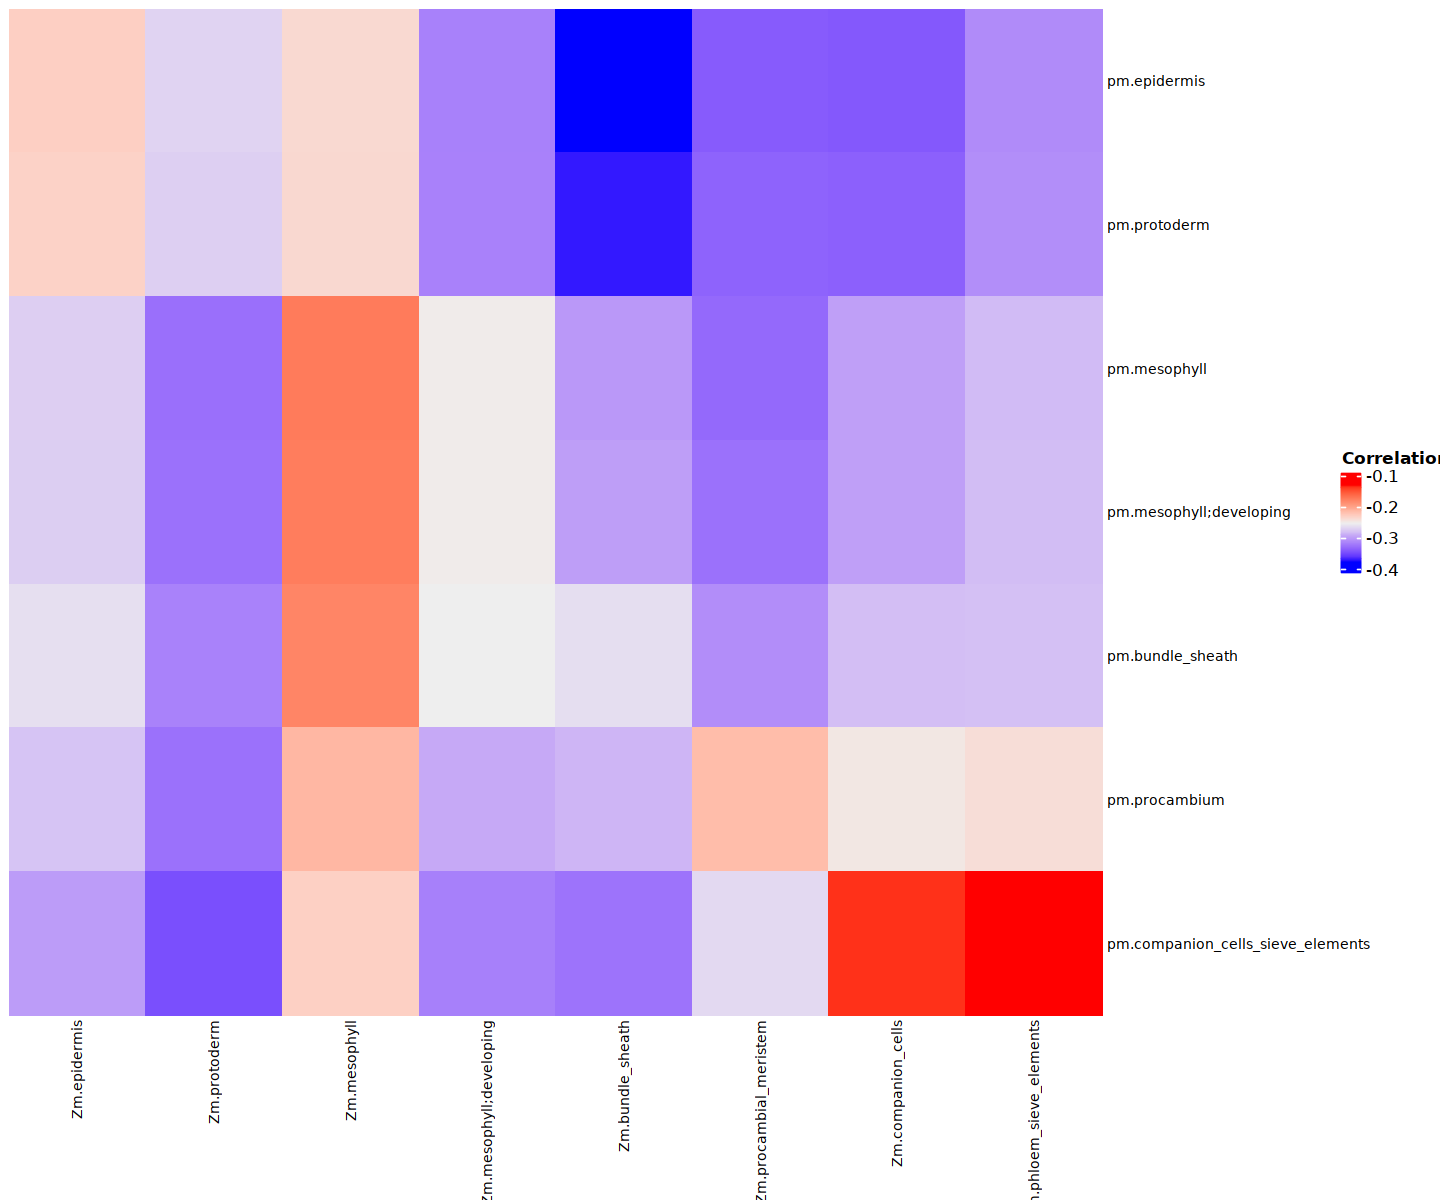

In [47]:
regression <- loess(logscore ~ species, data=combined_pm_zm.subset.mean.var)

combined_pm_zm.subset.mean.var.final <- combined_pm_zm.subset.mean.var %>% 
    add_residuals(regression)  %>% 
    arrange(resid, desc = FALSE)  %>% 
    top_n(1000)

combined_pm_zm.subset.mean.var.final.split <- combined_pm_zm.subset.mean.var.final  %>% 
    separate(ortho_unique, into = c("Orthogroup", "zm_gene", "Pm_gene"), sep = "__")  %>% 
    dplyr::select(Orthogroup, zm_gene, Pm_gene)

pm.cell_types.var_orthos.final <- left_join(combined_pm_zm.subset.mean.var.final.split, pm.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -Pm_gene)  %>% 
    replace(is.na(.), 0)

zm.cell_types.var_orthos.final <- left_join(combined_pm_zm.subset.mean.var.final.split,zm.cell_types.all_orthos)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -Pm_gene)  %>% 
    replace(is.na(.), 0)


pm.cell_types.acc_quant <- pm.cell_types.all_orthos  %>%
    dplyr::filter(Orthogroup %in% combined_pm_zm.subset.mean.var.final.split$Orthogroup)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -Pm_gene)  %>% 
    replace(is.na(.), 0)

zm.cell_types.acc_quant <- zm.cell_types.all_orthos  %>% 
    dplyr::filter(Orthogroup %in% combined_pm_zm.subset.mean.var.final.split$Orthogroup)  %>% 
    dplyr::select(-Orthogroup, -zm_gene, -Pm_gene)  %>% 
    replace(is.na(.), 0)



pm_order <- c('pm.epidermis',
    'pm.protoderm',
    'pm.mesophyll',
    'pm.mesophyll;developing',
    'pm.bundle_sheath',
    'pm.procambium',
    'pm.companion_cells_sieve_elements')

zm_order <- c('Zm.epidermis',
'Zm.protoderm',
'Zm.mesophyll',
'Zm.mesophyll;developing',
'Zm.bundle_sheath',
'Zm.procambial_meristem',
'Zm.companion_cells',
'Zm.phloem_sieve_elements'
)


options(repr.plot.width=12, repr.plot.height=10)
var.orthos.final <- cor((pm.cell_types.var_orthos.final), (zm.cell_types.var_orthos.final))
zm_vs_pm_2000_orthos_ordered <- Heatmap(var.orthos.final,
        row_order = pm_order,
        column_order = zm_order,
                                      column_names_gp = grid::gpar(fontsize = 8),
                                      row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))
zm_vs_pm_2000_orthos_ordered

In [49]:
## Fix Regression: 
acc_by_cell_type_species <- combined_pm_zm.subset %>%
    pivot_longer(!ortho_unique, names_to = "cell_type", values_to = "score")  %>% 
    mutate(species = case_when(
    str_starts(cell_type, "pm") ~ "pm",
    str_starts(cell_type, "Zm") ~ "Zm"))  %>% 
    ungroup()  %>% 
  mutate(species_id = row_number()) %>%
  pivot_wider(names_from = species, values_from = species_id,
              values_fill = 0, values_fn = length)  %>% 
    mutate(logscore = log1p(score))


##mean_ortho_var_by_species  <- acc_by_cell_type_species %>% 
 #   group_by(ortho_unique,species)  %>% 
 #   summarize(mean = mean(score),
 #           var = var(score))  %>% 
 # mutate(species_id = row_number()) %>%
 # pivot_wider(names_from = species, values_from = species_id,
 #             values_fill = 0, values_fn = length)  %>% 
 #   ungroup()

In [50]:
head(acc_by_cell_type_species)

ortho_unique,cell_type,score,pm,Zm,logscore
<chr>,<chr>,<dbl>,<int>,<int>,<dbl>
OG0000003__Zm00001eb276920__RLM98523.1,pm.bundle_sheath,14.09960,1,0,2.714669
OG0000003__Zm00001eb276920__RLM98523.1,pm.companion_cells_sieve_elements,17.30814,1,0,2.907346
OG0000003__Zm00001eb276920__RLM98523.1,pm.epidermis,23.13343,1,0,3.183598
OG0000003__Zm00001eb276920__RLM98523.1,pm.mesophyll,23.06098,1,0,3.180591
OG0000003__Zm00001eb276920__RLM98523.1,pm.mesophyll;developing,19.91217,1,0,3.040331
OG0000003__Zm00001eb276920__RLM98523.1,pm.procambium,25.01613,1,0,3.258717


In [75]:
#head(acc_by_species_mean_ave)
regression <- loess(logscore ~ Zm + pm, data=acc_by_cell_type_species)

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -0.010034 -0.010034”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2.0169”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 8.1356”


In [76]:
combined_pm_zm.subset.mean.var.final <- acc_by_cell_type_species %>% 
    add_residuals(regression)  %>% 
    arrange(resid, desc = FALSE)  

In [77]:
gathered_residuals <- combined_pm_zm.subset.mean.var.final  %>% 
    #separate(ortho_unique, into = c("Orthogroup", "zm_gene", "Pm_gene"), sep = "__")  %>% 
    dplyr::select(ortho_unique, cell_type, resid) %>% 
    pivot_wider(names_from = cell_type, values_from = resid)

In [56]:
head(gathered_residuals)

ortho_unique,Zm.procambial_meristem,Zm.companion_cells,Zm.mesophyll;developing,Zm.phloem_sieve_elements,Zm.protoderm,Zm.epidermis,Zm.bundle_sheath,Zm.mesophyll,pm.procambium,pm.companion_cells_sieve_elements,pm.mesophyll,pm.mesophyll;developing,pm.epidermis,pm.protoderm,pm.bundle_sheath
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OG0000004__Zm00001eb050830__RLN29177.1,-2.9126801,-0.8008140,-0.760533,-0.7430462,-0.2999212,-1.0729366,-1.383056,-1.0486823,-0.03437151,0.1937161,-1.138620,-0.7756097,-0.7250757,-0.4957025,-1.027916
OG0000007__Zm00001eb281100__RLN19337.1,-2.9126801,-2.9126801,-0.760533,-1.4791998,-0.3376923,-0.7708068,-1.307635,0.1286746,1.90369901,1.7398299,3.212753,3.1296468,2.9264653,2.8990470,3.110232
OG0000007__Zm00001eb116780__RLN19337.1,-2.9126801,-2.9126801,-1.650126,-1.5943738,-1.1990293,-0.4479209,-1.464633,-1.6369466,1.90369901,1.7398299,3.212753,3.1296468,2.9264653,2.8990470,3.110232
OG0000007__Zm00001eb305300__RLN19337.1,-0.4220003,-0.5159204,-2.912680,-0.2258241,0.8533066,0.8489334,-0.536437,-0.8849628,1.90369901,1.7398299,3.212753,3.1296468,2.9264653,2.8990470,3.110232
OG0000007__Zm00001eb416470__RLN19337.1,-2.9126801,-1.8773939,-1.650126,-2.0504050,-1.4001377,-1.3894793,-1.880129,-1.6369466,1.90369901,1.7398299,3.212753,3.1296468,2.9264653,2.8990470,3.110232
OG0000007__Zm00001eb281090__RLN19337.1,-2.9126801,-1.0489510,-1.109507,-1.0448592,-0.2284069,0.4491195,-1.052537,-0.8121679,1.90369901,1.7398299,3.212753,3.1296468,2.9264653,2.8990470,3.110232


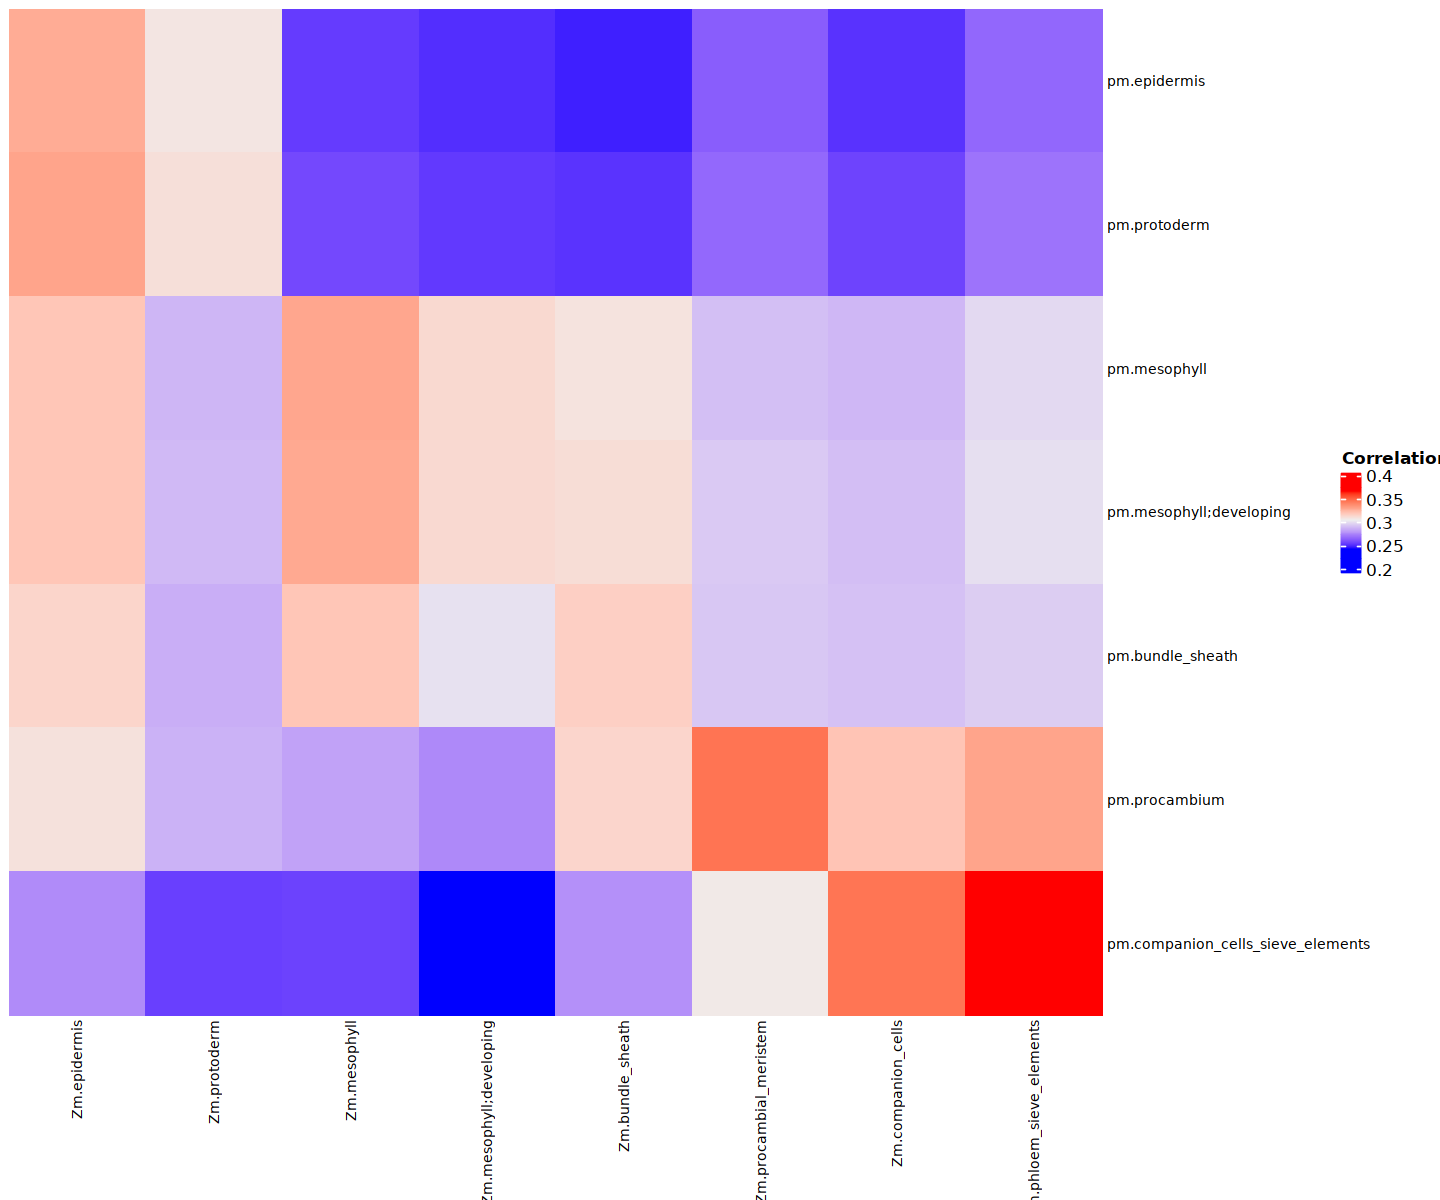

In [81]:

resid_var <- gathered_residuals  %>% 
    mutate(variation = rowSums((select(., -ortho_unique) - rowMeans(select(., -ortho_unique)))^2)) %>%
    arrange(desc(abs(variation)))

'%ni%' <- Negate("%in%")
filter_large_outliers <- resid_var %>%
    top_frac(n = 0.001,wt = variation)

# Select the top 1000 most variable rows
top_1000 <- resid_var %>%
    dplyr::filter(ortho_unique %ni% filter_large_outliers$ortho_unique)  %>% 
    head(10000)





zm_residuals <- gathered_residuals  %>% 
    dplyr::select(ortho_unique, Zm.procambial_meristem:Zm.mesophyll)  %>% 
    dplyr::filter(ortho_unique %in% top_1000$ortho_unique)  %>% 
    select(-ortho_unique)
pm_residuals <- gathered_residuals  %>% 
    dplyr::select(ortho_unique, pm.procambium:pm.bundle_sheath)  %>% 
    dplyr::filter(ortho_unique %in% top_1000$ortho_unique)  %>% 
    select(-ortho_unique)



zm_residuals[is.na(zm_residuals)] = 0
pm_residuals[is.na(pm_residuals)] = 0



pm_order <- c('pm.epidermis',
    'pm.protoderm',
    'pm.mesophyll',
    'pm.mesophyll;developing',
    'pm.bundle_sheath',
    'pm.procambium',
    'pm.companion_cells_sieve_elements')

zm_order <- c('Zm.epidermis',
'Zm.protoderm',
'Zm.mesophyll',
'Zm.mesophyll;developing',
'Zm.bundle_sheath',
'Zm.procambial_meristem',
'Zm.companion_cells',
'Zm.phloem_sieve_elements'
)


options(repr.plot.width=12, repr.plot.height=10)
var.orthos.final <- cor((pm_residuals), (zm_residuals))
zm_vs_pm_2000_orthos_ordered <- Heatmap(var.orthos.final,
        row_order = pm_order,
        column_order = zm_order,
    column_names_gp = grid::gpar(fontsize = 8),
    row_names_gp = grid::gpar(fontsize = 8),
    heatmap_legend_param = list(
        title = "Correlation",
        legend_width = unit(6, "cm")))
zm_vs_pm_2000_orthos_ordered

In [80]:
head(pm_residuals)

pm.procambium,pm.companion_cells_sieve_elements,pm.mesophyll,pm.mesophyll;developing,pm.epidermis,pm.protoderm,pm.bundle_sheath
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20.57627,14.919293,121.7289893,110.677787,87.22913,84.41421,108.225791
20.57627,14.919293,121.7289893,110.677787,87.22913,84.41421,108.225791
20.57627,14.919293,121.7289893,110.677787,87.22913,84.41421,108.225791
20.57627,14.919293,121.7289893,110.677787,87.22913,84.41421,108.225791
20.57627,14.919293,121.7289893,110.677787,87.22913,84.41421,108.225791
-11.02305,-4.311969,-0.6514437,-5.659458,40.28187,35.62143,-9.713252


In [83]:
## Saving all heatmaps 

pdf(file="/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/ct_correlation_heatmaps/Zm_vs_pm_marker_corr_3K_acrs.pdf", width = 8, heigh = 5)
zm_vs_pm_2000_orthos_ordered
dev.off()


pdf(file="/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/ct_correlation_heatmaps/Zm_vs_pm_marker_corr.pdf", width = 8, heigh = 5)
zm_pm_markers
dev.off()


#pdf(file="/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/ct_correlation_heatmaps/Zm_vs_sb_2000_var_orthos_ct_correlation.pdf", width = 8, heigh = 5)
#zm_vs_sb_2000_orthos_ordered
#dev.off()


#pdf(file="/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/ct_correlation_heatmaps/Sb_vs_sb_2000_var_orthos.ct_correlation.pdf", width = 8, heigh = 5)
#sb_vs_sb_2000_orthos
#dev.off()


#pdf(file="/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/ct_correlation_heatmaps/Zm_vs_zm_2000_var_orthos.ct_correlation.pdf", width = 8, heigh = 5)
#zm_vs_zm_2000_orthos
#dev.off()



png 
  2

png 
  2